# Fake News Detection

Fake news is created to intentionally misinform readers. The spread of fake news has long been a problem, but with the introduction of social media, its spread has increased in both quantity and speed of spread. It is continually becoming increasingly difficult to differentiate between real and fake news - even formal news institutions have been involved in spreading fake news in their haste to attempt to keep up with other news-producing outlets.

There are serious negative consequences of the spread of fake news. News has the ability to change opinions, influence decisions and drive actions - if all of this is based on a lie, the impacts on individuals and society could be extremely detrimental. Furthermore, the increase in fake news impacts the way people respond to the news, encouraging distrust in all news - even that which is legitimate - influence financial markets, disrupt political process, and damage reputations.

The purpose of this notebook is to build a model using machine learning and NLP to predict whether a news story is real or fake.

The dataset used will be a fake news dataset found on Kaggle through the following link: https://www.kaggle.com/c/fake-news/data

The train.csv will be used. It has the following attributes:
+ id: unique id for a news article
+ title: the title of a news article
+ author: author of the news article
+ text: the text of the article; could be incomplete
+ label: a label that marks the article as potentially unreliable (1: unreliable; 0: reliable)


In [200]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, learning_curve
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
import itertools
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import  LogisticRegression, SGDClassifier

from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score, classification_report, precision_recall_curve, average_precision_score
import spacy
import en_core_web_sm
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import string
import re
import nltk
import collections
from nltk.corpus import stopwords
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from empath import Empath

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import pickle

## 1. Loading and cleaning the data

In [2]:
df = pd.read_csv('data/train.csv')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
#Selecting few columns from the table and renaming the columns
df = df[['title','text','label']]
df.columns = ['Headline', 'Body', 'Label']
df.loc[df['Label']== 0, 'Label'] = 'REAL'
df.loc[df['Label']== 1, 'Label'] = 'FAKE'
df['Label'].value_counts()

FAKE    10413
REAL    10387
Name: Label, dtype: int64

In [4]:
#data observation
def data_obs():
    print("training dataset size:")
    print(df.shape)
    print(df.head(10))

#check the data by calling below function
data_obs()

training dataset size:
(20800, 3)
                                            Headline  \
0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2                  Why the Truth Might Get You Fired   
3  15 Civilians Killed In Single US Airstrike Hav...   
4  Iranian woman jailed for fictional unpublished...   
5  Jackie Mason: Hollywood Would Love Trump if He...   
6  Life: Life Of Luxury: Elton John’s 6 Favorite ...   
7  Benoît Hamon Wins French Socialist Party’s Pre...   
8  Excerpts From a Draft Script for Donald Trump’...   
9  A Back-Channel Plan for Ukraine and Russia, Co...   

                                                Body Label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...  FAKE  
1  Ever get the feeling your life circles the rou...  REAL  
2  Why the Truth Might Get You Fired October 29, ...  FAKE  
3  Videos 15 Civilians Killed In Single US Airstr...  FAKE  
4  Print \nAn Iranian woman has been sentenc

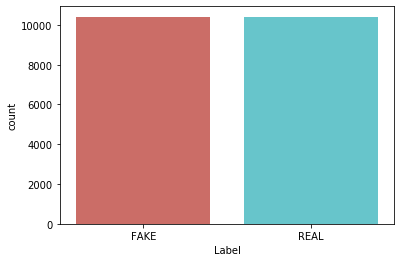

In [5]:
#distribution of classes for prediction
def create_distribution(dataFile):
    
    return sns.countplot(x='Label', data=dataFile, palette='hls')

create_distribution(df)

In [6]:
#data integrity check (missing label values)
#none of the datasets contains missing values therefore no cleaning required
def data_qualityCheck():
    
    print("Checking data qualitites...")
    df.isnull().sum()
    df.info()
        
#run the below function call to see the quality check results
data_qualityCheck()

Checking data qualitites...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 3 columns):
Headline    20242 non-null object
Body        20761 non-null object
Label       20800 non-null object
dtypes: object(3)
memory usage: 487.6+ KB


In [7]:
#drop duplicates
df = df.drop_duplicates()

In [8]:
df['Label'].value_counts()

REAL    10387
FAKE    10303
Name: Label, dtype: int64

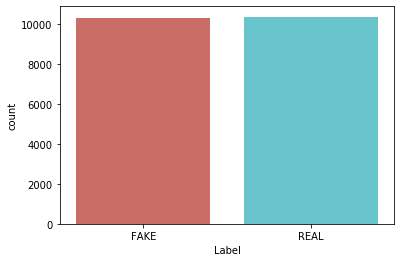

In [9]:
create_distribution(df)

In [10]:
df['headline_length'] = [len(str(a)) for a in df['Headline']]
df['headline_length'].describe()

count    20690.000000
mean        72.567134
std         25.434623
min          3.000000
25%         59.000000
50%         75.000000
75%         87.000000
max        456.000000
Name: headline_length, dtype: float64

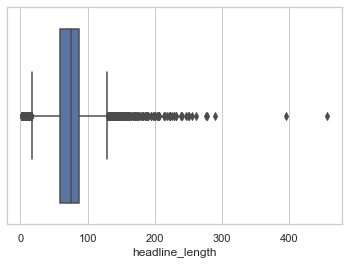

In [11]:
sns.set(style="whitegrid")
ax = sns.boxplot(x=df["headline_length"])

In [12]:
df['body_length'] = [len(str(a)) for a in df['Body']]
df['body_length'].describe()

count     20690.000000
mean       4546.225761
std        5126.623859
min           1.000000
25%        1625.000000
50%        3355.000000
75%        6273.750000
max      142961.000000
Name: body_length, dtype: float64

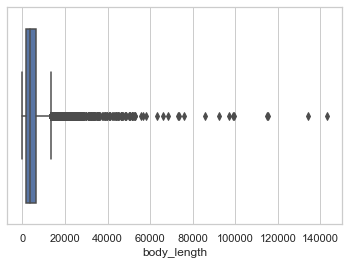

In [13]:
sns.set(style="whitegrid")
ax = sns.boxplot(x=df["body_length"])

In [14]:
#remove entries with headline over 300 words and body over 100,000 or under 10
df = df[df['headline_length'] < 300]
df = df[(df['body_length'] < 100000) & (df['body_length'] >= 10)]

## 2. Creating features

1. The title and body will be combined
2. the POS tags for text will be created
3. Empath will be used to generate semantic categories and create a tfidf vector of the unigrams

In [15]:
#combine headline and body
df["Text"] = df["Headline"].map(str) + ' ' + df["Body"]

#extract labels as y
y = df.Label
y = y.astype('str')

In [16]:
#Generating the POS tags for all the articles and adding a new column by replacing text with their POS tags
#nlp = spacy.load('en_core_web_sm')
nlp = en_core_web_sm.load()
x = []
for text in df['Text']:
    text_new = []
    doc = nlp(text)
    for token in doc:
        text_new.append(token.pos_)
    txt = ' '.join(text_new)
    x.append(txt)
df['Text_pos'] = x

In [17]:
#Getting the score of semantic categories generated by Empath of each article and generating a tfidf vector of the unigrams 
lexicon = Empath()
semantic = []
cnt = 0

for article in df['Text']:
    if article == '':
        continue
    cnt+=1
    d = lexicon.analyze(article, normalize = False)
    x = []
    for key, value in d.items():
        x.append(value)
    x = np.asarray(x)
    semantic.append(x)
df['Semantic'] = semantic


categories = []
a = lexicon.analyze("")
for key, value in a.items():
    categories.append(key)
categories


#TF-IDF vector by taking the score for a semantic class as its frequency.
sem = []
for i in range(df.shape[0]):
    a = []
    for j in range(len(semantic[0])):
        for k in range(int(semantic[i][j])):
            a.append(categories[j])
    b = " ".join(a)
    sem.append(b)

df['Semantics'] = sem

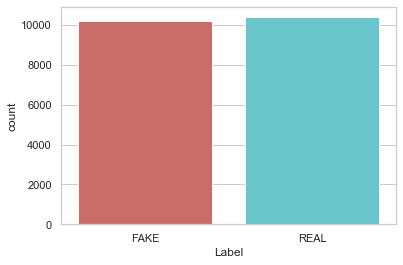

In [18]:
create_distribution(df)

In [19]:
df.head()

,Headline,Body,Label,headline_length,body_length,Text,Text_pos,Semantic,Semantics
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,FAKE,81,4930,House Dem Aide: We Didn’t Even See Comey’s Let...,PROPN PROPN PROPN PUNCT PRON AUX PART ADV VERB...,"[2.0, 2.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",help help office office dance money money cold...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,REAL,55,4160,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",PROPN PUNCT PROPN PROPN PUNCT PROPN PROPN ADP ...,"[2.0, 0.0, 2.0, 0.0, 3.0, 0.0, 0.0, 0.0, 1.0, ...",help help dance dance wedding wedding wedding ...
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",FAKE,33,7692,Why the Truth Might Get You Fired Why the Trut...,ADV DET PROPN VERB AUX PRON VERB ADV DET NOUN ...,"[3.0, 5.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",help help help office office office office off...
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,FAKE,63,3237,15 Civilians Killed In Single US Airstrike Hav...,NUM PROPN VERB ADP ADJ PROPN NOUN AUX AUX VERB...,"[0.0, 0.0, 0.0, 0.0, 3.0, 3.0, 0.0, 3.0, 0.0, ...",wedding wedding wedding domestic_work domestic...
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,FAKE,93,938,Iranian woman jailed for fictional unpublished...,ADJ NOUN VERB ADP ADJ ADJ NOUN ADP NOUN VERB A...,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",wedding domestic_work family family crime crim...


In [182]:
df.to_csv('data/prepared_data.csv')

## 3. Split data into train and test sets

The train data will be used to train the models - K-fold cross validation will be used to find the model that performs the best on the training data. The entire train dataset will be used to build the model once the best one is found.

The test data will be used at the end in order to ascertain how the final model performs on unseen data.

In [20]:
#split to train and test sets to validate model at the end
X_train, X_test, Y_train, Y_test = train_test_split(df[['Text','Text_pos','Semantics']], y, test_size=0.2)
X_train.head()

,Text,Text_pos,Semantics
13377,Trump Team Begins Making List Of Executive Ord...,PROPN PROPN VERB VERB PROPN ADP PROPN PROPN PA...,office office wedding wedding domestic_work do...
16069,Is Something Wrong With Hillary? Will NOT Conc...,AUX PRON ADJ ADP PROPN PUNCT VERB ADV VERB NOU...,help medical_emergency vacation health pride g...
12230,Things I Wish I Had Known When My Dog Died - T...,NOUN PRON VERB PRON AUX VERB ADV DET NOUN VERB...,office money wedding wedding wedding domestic_...
11644,#GrammysSoWhite Came to Life. Will the Awards ...,PROPN PROPN VERB ADP PROPN PUNCT VERB DET PROP...,help help office office dance dance dance danc...
11547,Aussie Muslims Demand ’Safe Spaces’ so Followe...,PROPN PROPN NOUN PUNCT PROPN NOUN PUNCT ADV NO...,dance dance dance money wedding cold hate aggr...


In [21]:
#create separate train sets based on pre-processing conducted on the text
X_train_text = X_train['Text']
X_train_pos = X_train['Text_pos']
X_train_sem = X_train['Semantics']

X_test_text = X_test['Text']
X_test_pos = X_test['Text_pos']
X_test_sem = X_test['Semantics']

## 4. Investigating models using K-fold cross-validation

For each train set version - text (bag-of-words), text (tf-idf bigrams), pos and semantics - multiple classifiers will be tested with K-fold cross validation. These classifiers are:
+ Multinomial Naive Bayes
+ Logisitc Regression
+ Linear SVM
+ SVM Stochastic Gradient Descent
+ Random Forest
+ Gradient Boosting

In [22]:
#function for K-Fold cross validation
def build_confusion_matrix(classifier, X_train, Y_train):
    
    k_fold = KFold(n_splits=5)
    scores = []
    confusion = np.array([[0,0],[0,0]])

    for train_ind, test_ind in k_fold.split(X_train):
        train_text = X_train.iloc[train_ind]
        train_y = Y_train.iloc[train_ind]
    
        test_text = X_train.iloc[test_ind]
        test_y = Y_train.iloc[test_ind]
        
        classifier.fit(train_text,train_y)
        predictions = classifier.predict(test_text)
        
        confusion += confusion_matrix(test_y, predictions)
        score = f1_score(test_y, predictions, pos_label='REAL')
        scores.append(score)
    
    print('Total statements classified:', len(X_train)),
    print('Average f1 score from 5-fold cross-validation:', sum(scores)/len(scores)),
    plot_confusion_matrix(confusion, classes=['FAKE', 'REAL'])
    

# plot Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### 4.1 Generating News Feature Vector using Bag of Words

For this, all unique words in all text extracts are collected and the texts are represented in a vector of all unique words by counting the number of times each word appears in that text. With this approach, the order of words or structure of sentences is not considered - only the presence of a word in the text.

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

#we will start with simple bag of words technique 
#creating feature vector - document term matrix
countV = CountVectorizer()
#train_count = countV.fit_transform(X_train.values)

print(countV)
#print(train_count)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)


Total statements classified: 16447
Average f1 score from 5-fold cross-validation: 0.9135902326515183
Confusion matrix


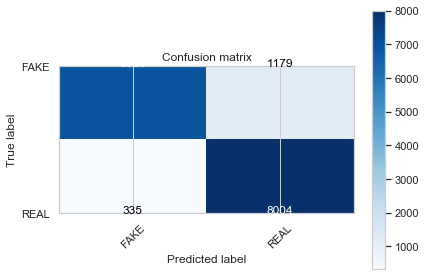

In [25]:
#building classifier using naive bayes 
nb_pipeline = Pipeline([
        ('NBCV', countV),
        ('nb_clf', MultinomialNB())])

#K-fold cross validation for all classifiers
build_confusion_matrix(nb_pipeline, X_train_text, Y_train)

/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/lo

Total statements classified: 16447
Average f1 score from 5-fold cross-validation: 0.9660630104001804
Confusion matrix


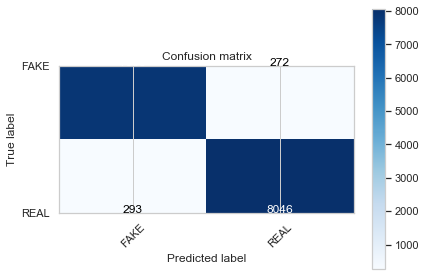

In [26]:
#building classifier using logistic regression
logR_pipeline = Pipeline([
        ('LogRCV', countV),
        ('LogR_clf', LogisticRegression())
        ])

build_confusion_matrix(logR_pipeline, X_train_text, Y_train)

/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: Conver

Total statements classified: 16447
Average f1 score from 5-fold cross-validation: 0.9607881657920586
Confusion matrix


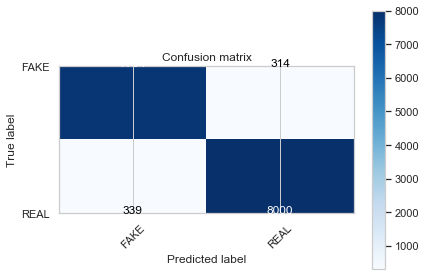

In [27]:
#building Linear SVM classfier
svm_pipeline = Pipeline([
        ('svmCV', countV),
        ('svm_clf', svm.LinearSVC())
        ])

build_confusion_matrix(svm_pipeline, X_train_text, Y_train)

Total statements classified: 16447
Average f1 score from 5-fold cross-validation: 0.9581881712852105
Confusion matrix


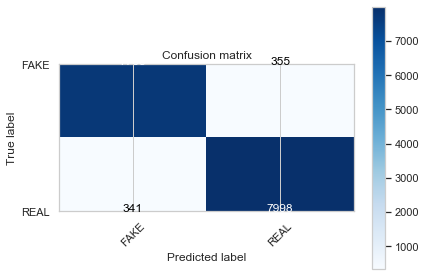

In [28]:
#using SVM Stochastic Gradient Descent on hinge loss
sgd_pipeline = Pipeline([
        ('svm2CV', countV),
        ('svm2_clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3))
        ])

build_confusion_matrix(sgd_pipeline, X_train_text, Y_train)

Total statements classified: 16447
Average f1 score from 5-fold cross-validation: 0.935988265151282
Confusion matrix


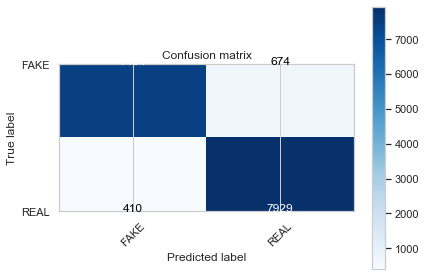

In [29]:
#random forest
random_forest = Pipeline([
        ('rfCV', countV),
        ('rf_clf', RandomForestClassifier(n_estimators=200,n_jobs=3))
        ])

build_confusion_matrix(random_forest, X_train_text, Y_train)

Total statements classified: 16447
Average f1 score from 5-fold cross-validation: 0.9612479583409546
Confusion matrix


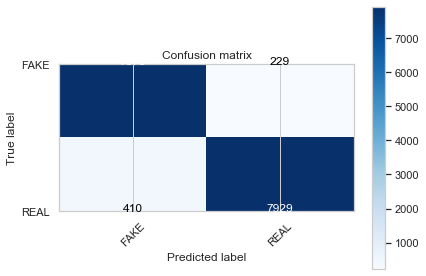

In [30]:
#gradient boosting classifier
gradient_boosting = Pipeline([
        ('gb_tfidf', countV),
        ('gb_clf', GradientBoostingClassifier())
        ])

build_confusion_matrix(gradient_boosting, X_train_text, Y_train)

### 4.2 TF-IDF Bigrams

TF-IDF (term frequency-inverse document frequency) is a numerical statistic that shows how important a word is to a document in a corpus. The importance of a word is proportional to the number of times the word appears in the text but inversely proportional to the number of times the word appears in the corpus. For generating the news vector here, the tf-idf bigram values will be calculated and vectorised.

In [31]:
#Initialise the `tfidf_vectorizer` 
tfidf_ngram = TfidfVectorizer(stop_words='english', ngram_range=(2,2), use_idf=True, smooth_idf=True)

Total statements classified: 16447
Average f1 score from 5-fold cross-validation: 0.9282391289625658
Confusion matrix


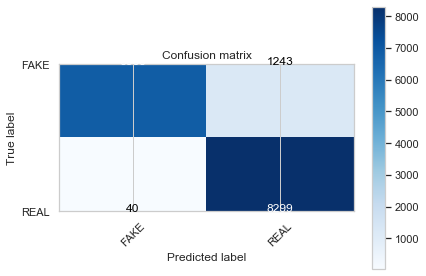

In [32]:
#naive-bayes classifier
nb_pipeline_ngram = Pipeline([
        ('nb_tfidf', tfidf_ngram),
        ('nb_clf', MultinomialNB())])

#K-fold cross validation 
build_confusion_matrix(nb_pipeline_ngram, X_train_text, Y_train)

/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/lo

Total statements classified: 16447
Average f1 score from 5-fold cross-validation: 0.9580516893609303
Confusion matrix


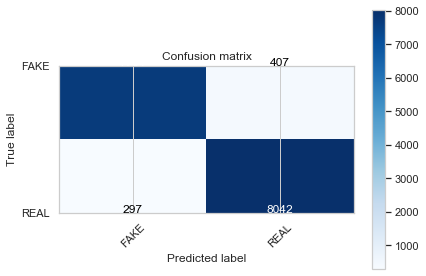

In [33]:
#logistic regression classifier
logR_pipeline_ngram = Pipeline([
        ('LogR_tfidf', tfidf_ngram),
        ('LogR_clf', LogisticRegression(penalty="l2",C=1))
        ])

build_confusion_matrix(logR_pipeline_ngram, X_train_text, Y_train)

Total statements classified: 16447
Average f1 score from 5-fold cross-validation: 0.9691406466997042
Confusion matrix


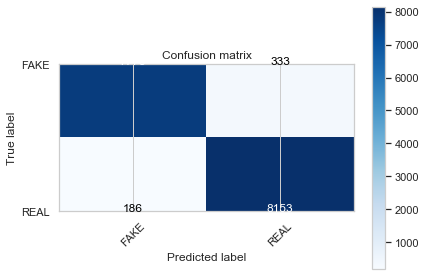

In [34]:
#linear SVM classifier
svm_pipeline_ngram = Pipeline([
        ('svm_tfidf', tfidf_ngram),
        ('svm_clf', svm.LinearSVC())
        ])

build_confusion_matrix(svm_pipeline_ngram, X_train_text, Y_train)

Total statements classified: 16447
Average f1 score from 5-fold cross-validation: 0.8619455627737649
Confusion matrix


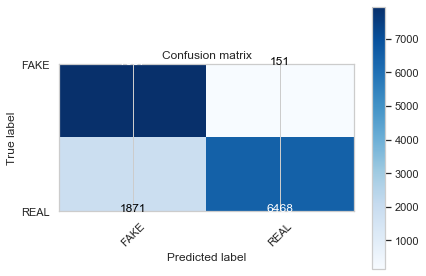

In [36]:
#sgd classifier
sgd_pipeline_ngram = Pipeline([
         ('sgd_tfidf', tfidf_ngram),
         ('sgd_clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3))
         ])

build_confusion_matrix(sgd_pipeline_ngram, X_train_text, Y_train)

Total statements classified: 16447
Average f1 score from 5-fold cross-validation: 0.9494649439662194
Confusion matrix


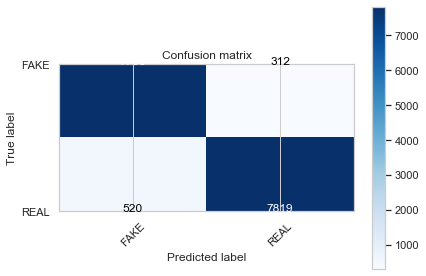

In [37]:
#random forest classifier
random_forest_ngram = Pipeline([
        ('rf_tfidf', tfidf_ngram),
        ('rf_clf', RandomForestClassifier(n_estimators=300,n_jobs=3))
        ])

build_confusion_matrix(random_forest_ngram, X_train_text, Y_train)

Total statements classified: 16447
Average f1 score from 5-fold cross-validation: 0.9275176280415632
Confusion matrix


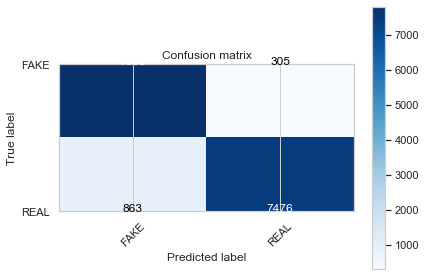

In [38]:
#gradient boosting classifier
gradient_boosting_ngram = Pipeline([
        ('gb_tfidf', tfidf_ngram),
        ('gb_clf', GradientBoostingClassifier())
        ])

build_confusion_matrix(gradient_boosting_ngram, X_train_text, Y_train)

### 4.3 POS (part-of-speech) tags

POS features are encoded as tf-idf values for each of the tags. As POS tags are not as effective as words, POS features are strengthened with unigram/bigram features.

POS features were generated above.

In [39]:
#Initialise the tfidf_vectorizer
tfidf_pos = TfidfVectorizer(stop_words='english', ngram_range=(2,2), use_idf=True, smooth_idf=True)

Total statements classified: 16447
Average f1 score from 5-fold cross-validation: 0.9166692931266077
Confusion matrix


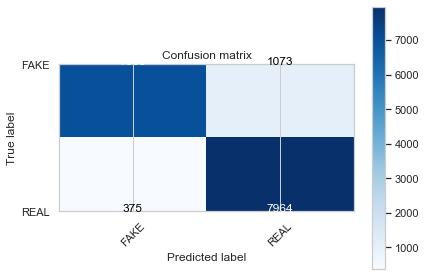

In [40]:
#naive-bayes classifier
nb_pipeline_pos = Pipeline([
        ('nb_tfidf', tfidf_pos),
        ('nb_clf', MultinomialNB())])

#K-fold cross validation 
build_confusion_matrix(nb_pipeline_pos, X_train_pos, Y_train)

/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/lo

Total statements classified: 16447
Average f1 score from 5-fold cross-validation: 0.9377615946233663
Confusion matrix


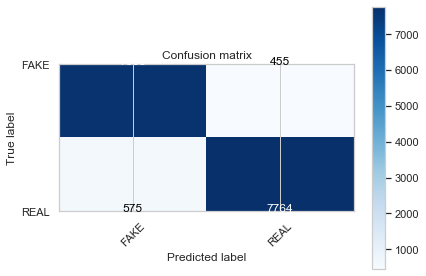

In [41]:
#logistic regression classifier
logR_pipeline_pos = Pipeline([
        ('LogR_tfidf', tfidf_pos),
        ('LogR_clf', LogisticRegression(penalty="l2",C=1))
        ])

build_confusion_matrix(logR_pipeline_pos, X_train_pos, Y_train)

Total statements classified: 16447
Average f1 score from 5-fold cross-validation: 0.95123949816804
Confusion matrix


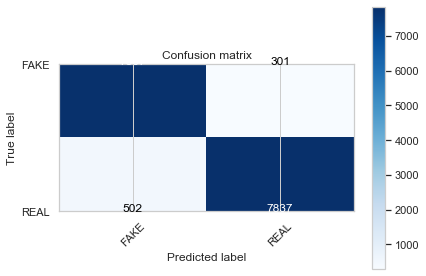

In [42]:
#linear SVM classifier
svm_pipeline_pos = Pipeline([
        ('svm_tfidf', tfidf_pos),
        ('svm_clf', svm.LinearSVC())
        ])

build_confusion_matrix(svm_pipeline_pos, X_train_pos, Y_train)

Total statements classified: 16447
Average f1 score from 5-fold cross-validation: 0.9205193335102033
Confusion matrix


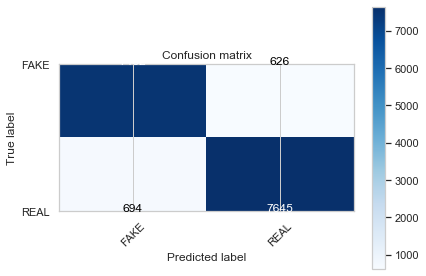

In [43]:
#sgd classifier
sgd_pipeline_pos = Pipeline([
         ('sgd_tfidf', tfidf_pos),
         ('sgd_clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3))
         ])

build_confusion_matrix(sgd_pipeline_pos, X_train_pos, Y_train)

Total statements classified: 16447
Average f1 score from 5-fold cross-validation: 0.9642453512630162
Confusion matrix


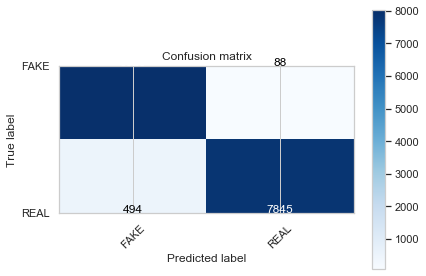

In [44]:
#random forest classifier
random_forest_pos = Pipeline([
        ('rf_tfidf', tfidf_pos),
        ('rf_clf', RandomForestClassifier(n_estimators=300,n_jobs=3))
        ])

build_confusion_matrix(random_forest_pos, X_train_pos, Y_train)

Total statements classified: 16447
Average f1 score from 5-fold cross-validation: 0.9638369320275799
Confusion matrix


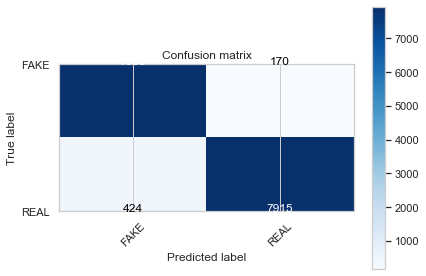

In [45]:
#gradient boosting classifier
gradient_boosting_pos = Pipeline([
        ('gb_tfidf', tfidf_pos),
        ('gb_clf', GradientBoostingClassifier())
        ])

build_confusion_matrix(gradient_boosting_pos, X_train_pos, Y_train)

### 4.4 Semantic Categories

Empath was used above for incorporating semantic information. Empath is a lexicon of words grouped into semantic categories relevant to psychological processes. It has 194 semantic categories. A score is generated between 0-100 for each semantic class. The lexicon obtained is converted to a tf-idf vector by taking the score for a semantic class as its frequency.

In [46]:
#Initialise the `tfidf_vectorizer` 
tfidf_sem = TfidfVectorizer(stop_words='english', ngram_range=(1,1), use_idf=True, smooth_idf=True)

Total statements classified: 16447
Average f1 score from 5-fold cross-validation: 0.6720291978222526
Confusion matrix


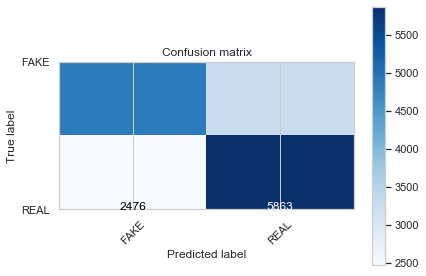

In [47]:
#naive-bayes classifier
nb_pipeline_sem = Pipeline([
        ('nb_tfidf', tfidf_sem),
        ('nb_clf', MultinomialNB())])

#K-fold cross validation 
build_confusion_matrix(nb_pipeline_sem, X_train_sem, Y_train)

/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/lo

Total statements classified: 16447
Average f1 score from 5-fold cross-validation: 0.7381973712864203
Confusion matrix


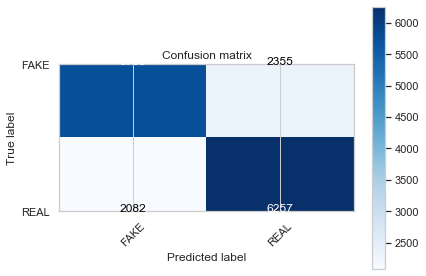

In [48]:
#logistic regression classifier
logR_pipeline_sem = Pipeline([
        ('LogR_tfidf', tfidf_sem),
        ('LogR_clf', LogisticRegression(penalty="l2",C=1))
        ])

build_confusion_matrix(logR_pipeline_sem, X_train_sem, Y_train)

Total statements classified: 16447
Average f1 score from 5-fold cross-validation: 0.7390904962905848
Confusion matrix


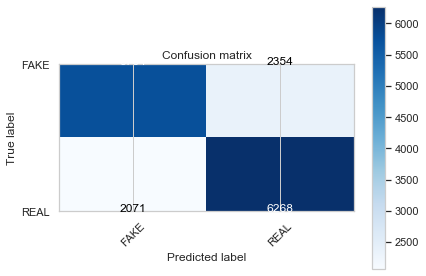

In [49]:
#linear SVM classifier
svm_pipeline_sem = Pipeline([
        ('svm_tfidf', tfidf_sem),
        ('svm_clf', svm.LinearSVC())
        ])

build_confusion_matrix(svm_pipeline_sem, X_train_sem, Y_train)

Total statements classified: 16447
Average f1 score from 5-fold cross-validation: 0.7344995775310796
Confusion matrix


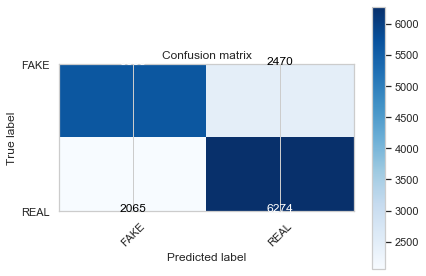

In [50]:
#sgd classifier
sgd_pipeline_sem = Pipeline([
         ('sgd_tfidf', tfidf_sem),
         ('sgd_clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3))
         ])

build_confusion_matrix(sgd_pipeline_sem, X_train_sem, Y_train)

Total statements classified: 16447
Average f1 score from 5-fold cross-validation: 0.7731265696735111
Confusion matrix


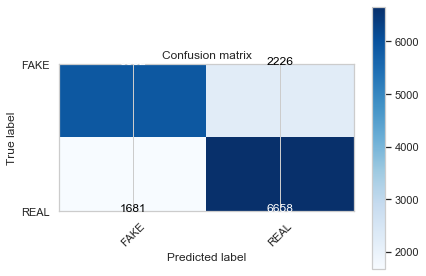

In [51]:
#random forest classifier
random_forest_sem = Pipeline([
        ('rf_tfidf', tfidf_sem),
        ('rf_clf', RandomForestClassifier(n_estimators=300,n_jobs=3))
        ])

build_confusion_matrix(random_forest_sem, X_train_sem, Y_train)

Total statements classified: 16447
Average f1 score from 5-fold cross-validation: 0.7560927063104147
Confusion matrix


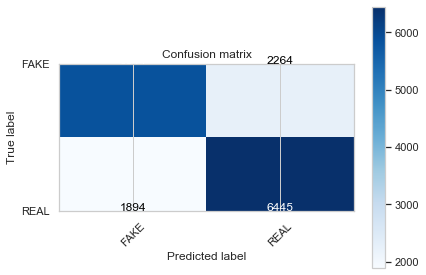

In [52]:
#gradient boosting classifier
gradient_boosting_sem = Pipeline([
        ('gb_tfidf', tfidf_sem),
        ('gb_clf', GradientBoostingClassifier())
        ])

build_confusion_matrix(gradient_boosting_sem, X_train_sem, Y_train)

## 5. Combined features news vector
### 5.1 All 4 vectors combined

In [53]:
#fit_transform X_train sets
train_bow = countV.fit_transform(X_train_text.astype('str'))
train_ngram = tfidf_ngram.fit_transform(X_train_text.astype('str'))
train_pos = tfidf_pos.fit_transform(X_train_pos.astype('str'))
train_sem = tfidf_sem.fit_transform(X_train_sem.astype('str'))

In [58]:
#Combining feature vectors for train set
import scipy.sparse as sp

#difference of number of rows between train sets
diff_n_rows = train_bow.shape[0] - train_ngram.shape[0]
X_new1 = sp.vstack((train_ngram, sp.csr_matrix((diff_n_rows, train_ngram.shape[1])))) 
X1 = sp.hstack((train_bow, X_new1))


diff_n_rows2 = X1.shape[0] - train_pos.shape[0]
X_new2 = sp.vstack((train_pos, sp.csr_matrix((diff_n_rows2, train_pos.shape[1])))) 
X2 = sp.hstack((X1, X_new2))


diff_n_rows3 = X2.shape[0] - train_sem.shape[0]
X_new3 = sp.vstack((train_sem, sp.csr_matrix((diff_n_rows3, train_sem.shape[1])))) 
X_train_com = sp.hstack((X2, X_new3))

#convert coo matrix to csr matrix
X_train_com1 = X_train_com.tocsr()


#as matrix has reset index, need to reset on Y_train
Y_train1 = Y_train.reset_index()
Y_train1 = Y_train1['Label']

In [163]:
#KFold function for matrix
#function for K-Fold cross validation
def build_confusion_matrix_com(classifier, X_train, Y_train):
    
    k_fold = KFold(n_splits=5)
    scores = []
    confusion = np.array([[0,0],[0,0]])

    for train_ind, test_ind in k_fold.split(X_train):
        train_text = X_train[train_ind]
        train_y = Y_train[train_ind]
    
        test_text = X_train[test_ind]
        test_y = Y_train[test_ind]
        
        classifier.fit(train_text,train_y)
        predictions = classifier.predict(test_text)
        
        confusion += confusion_matrix(test_y, predictions)
        score = f1_score(test_y, predictions, pos_label='REAL')
        scores.append(score)
    
    #print('Total statements classified:', X_train[0]),
    print('Average f1 score from 5-fold cross-validation:', sum(scores)/len(scores)),
    plot_confusion_matrix(confusion, classes=['FAKE', 'REAL'])

Average f1 score from 5-fold cross-validation: 0.819030868837007
Confusion matrix


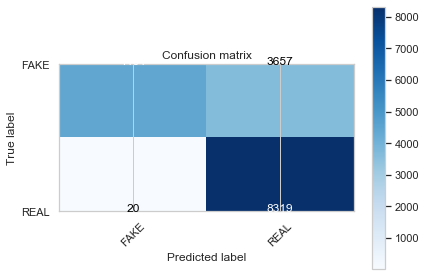

In [164]:
nb_com = MultinomialNB()

build_confusion_matrix_com(nb_com, X_train_com1, Y_train1)

/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Average f1 score from 5-fold cross-validation: 0.9661677910509742
Confusion matrix


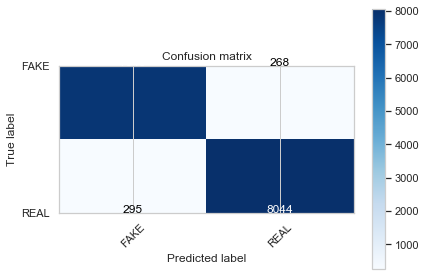

In [165]:
#logistic regression classifier
logR_com = LogisticRegression(penalty="l2",C=1)

build_confusion_matrix_com(logR_com, X_train_com1, Y_train1)

/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Average f1 score from 5-fold cross-validation: 0.9623026378957038
Confusion matrix


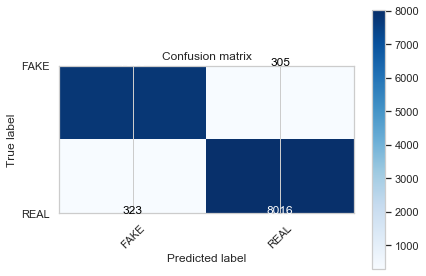

In [166]:
#linear SVM classifier
svm_com = svm.LinearSVC()

build_confusion_matrix_com(svm_com, X_train_com1, Y_train1)

Average f1 score from 5-fold cross-validation: 0.9610529175895092
Confusion matrix


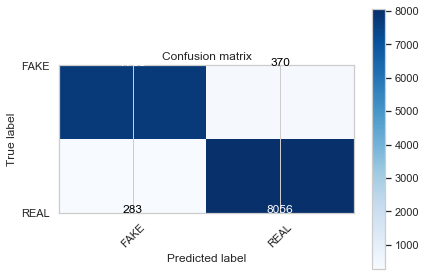

In [167]:
#sgd classifier
sgd_com = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3)

build_confusion_matrix_com(sgd_com, X_train_com1, Y_train1)

Average f1 score from 5-fold cross-validation: 0.9267531309555608
Confusion matrix


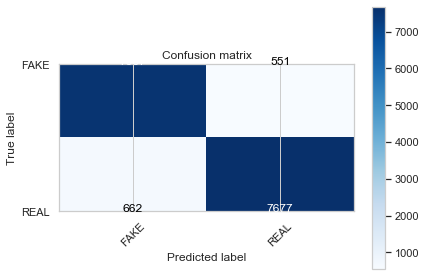

In [169]:
#random forest classifier
random_forest_com = RandomForestClassifier(n_estimators=300,n_jobs=3)

build_confusion_matrix_com(random_forest_com, X_train_com1, Y_train1)

Average f1 score from 5-fold cross-validation: 0.984849769793032
Confusion matrix


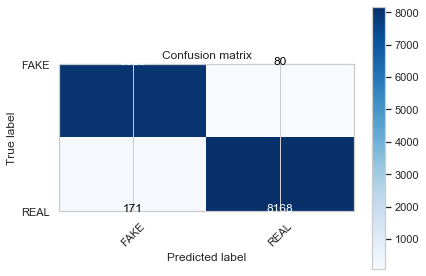

In [170]:
#gradient boosting classifier
gradient_boosting_com = GradientBoostingClassifier()

build_confusion_matrix_com(gradient_boosting_com, X_train_com1, Y_train1)

As none of these combined performs better than individually, and as performance on the semantics features was so low, we will try combining feature vectors with weights.

### 5.2 Weighting the feature vectors

First, will try with semantics variable set to 0, as this feature achieved the lowest performance scores for all classifiers.

In [171]:
#Giving weights to each of the 3 feature vectors generated
bow_w = 1/3
big_w = 1/3
pos_w = 1/3
sem_w = 0
bow_w *= 4
big_w *= 4
pos_w *= 4
sem_w *= 4

train_bow1 = bow_w*train_bow
train_ngram1 = big_w*train_ngram
train_pos1 = pos_w*train_pos
train_sem1 = sem_w*train_sem

test_bow1 = bow_w*test_bow
test_ngram1 = big_w*test_ngram
test_pos1 = pos_w*test_pos
test_sem1 = sem_w*test_sem

In [172]:
#Combining feature vectors for train set
import scipy.sparse as sp

#difference of number of rows between train sets
diff_n_rows = train_bow1.shape[0] - train_ngram1.shape[0]
X_new1 = sp.vstack((train_ngram1, sp.csr_matrix((diff_n_rows, train_ngram1.shape[1])))) 
X1 = sp.hstack((train_bow1, X_new1))


diff_n_rows2 = X1.shape[0] - train_pos1.shape[0]
X_new2 = sp.vstack((train_pos1, sp.csr_matrix((diff_n_rows2, train_pos1.shape[1])))) 
X2 = sp.hstack((X1, X_new2))


diff_n_rows3 = X2.shape[0] - train_sem1.shape[0]
X_new3 = sp.vstack((train_sem1, sp.csr_matrix((diff_n_rows3, train_sem1.shape[1])))) 
X_train_com = sp.hstack((X2, X_new3))

#convert coo matrix to csr matrix
X_train_com1 = X_train_com.tocsr()


#as matrix has reset index, need to reset on Y_train
Y_train1 = Y_train.reset_index()
Y_train1 = Y_train1['Label']

Average f1 score from 5-fold cross-validation: 0.8424134457927732
Confusion matrix


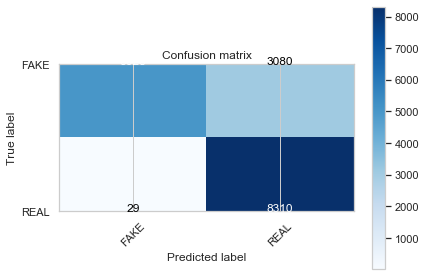

In [174]:
nb_com = MultinomialNB()

build_confusion_matrix_com(nb_com, X_train_com1, Y_train1)

/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Average f1 score from 5-fold cross-validation: 0.9662462275341948
Confusion matrix


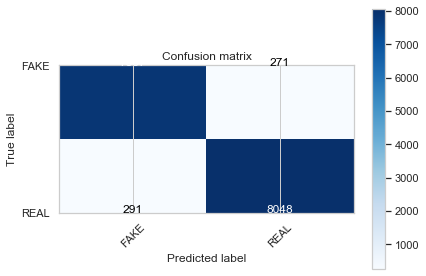

In [175]:
#logistic regression classifier
logR_com = LogisticRegression(penalty="l2",C=1)

build_confusion_matrix_com(logR_com, X_train_com1, Y_train1)

/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Average f1 score from 5-fold cross-validation: 0.9613403699709074
Confusion matrix


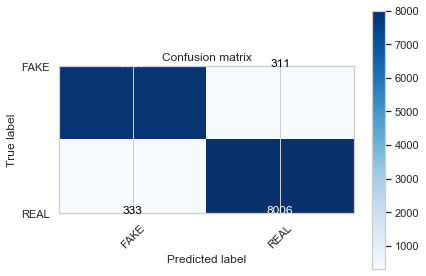

In [176]:
#linear SVM classifier
svm_com = svm.LinearSVC()

build_confusion_matrix_com(svm_com, X_train_com1, Y_train1)

Average f1 score from 5-fold cross-validation: 0.9590756704315023
Confusion matrix


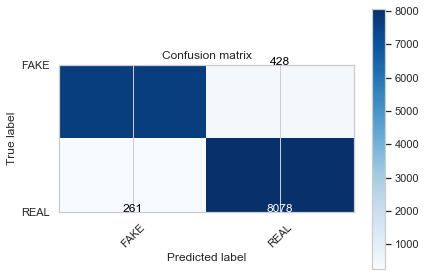

In [177]:
#sgd classifier
sgd_com = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3)

build_confusion_matrix_com(sgd_com, X_train_com1, Y_train1)

Average f1 score from 5-fold cross-validation: 0.940983100004666
Confusion matrix


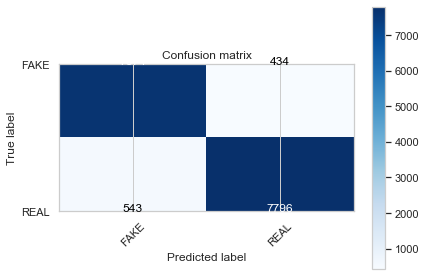

In [178]:
#random forest classifier
random_forest_com = RandomForestClassifier(n_estimators=300,n_jobs=3)

build_confusion_matrix_com(random_forest_com, X_train_com1, Y_train1)

Average f1 score from 5-fold cross-validation: 0.984975048255005
Confusion matrix


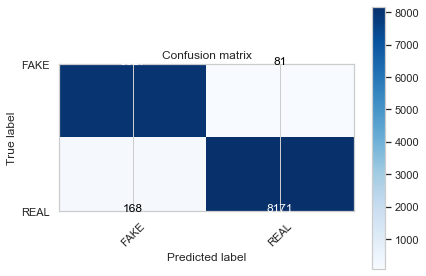

In [179]:
#gradient boosting classifier
gradient_boosting_com = GradientBoostingClassifier()

build_confusion_matrix_com(gradient_boosting_com, X_train_com1, Y_train1)

One thing to note is that for the combined data, all train data was fit_transformed before entering the matrix and k-fold cross-validation; this may have impacted the performance on predictions for CV test sets. However, for now, based on the results of k-fold CV, the best performing model will be trained on all the train data and used to predict the test set, with performance evaluated.    

The best performing model based on 5-fold cross-validation of the train set was: GradientBoostingClassifier with the X_train_com1 matrix with the bag-of-words, tf-idf ngrams and pos features.

## 6. Hyperparameter tuning

GridSearchCV can be used to optimise parameters for the GradientBoostingClassifier to see if performance of prediction can be improved further.

In [184]:
#learning rate
parameters = {"learning_rate": [0.001, 0.01, 0.05, 0.1, 0.15]}

tuning = GridSearchCV(GradientBoostingClassifier(), parameters, cv=3, n_jobs=-1)
tuning.fit(X_train_com1, Y_train1)

tuning.best_params_, tuning.best_score_

({'learning_rate': 0.15}, 0.9855292758557792)

In [185]:
#max depth
parameters = {
    "learning_rate": [0.15],
    "max_depth": [3,5,7]
}

tuning = GridSearchCV(GradientBoostingClassifier(), parameters, cv=3, n_jobs=-1)
tuning.fit(X_train_com1, Y_train1)
tuning.best_params_, tuning.best_score_

({'learning_rate': 0.15, 'max_depth': 3}, 0.9855900772177297)

## 7. Final model training

With the parameters found to be optimal, the GradientBoostingClassifier will now be trained on the train data that includes the bag-of-words, tf-idf ngram and pos features.

This final model will be saved and then used to make predictions on the test set.

In [192]:
gb_clf = GradientBoostingClassifier(learning_rate=0.15,
                                    max_depth=3
                                   )

gb_clf.fit(X_train_com1, Y_train1)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.15, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
#save model
filename = 'final_model.sav'
pickle.dump(gb_clf, open(filename, 'wb'))

## 8. Evaluation of model performance by generating predictions for the test set

In [201]:
final_model = pickle.load(open(filename, 'rb'))
final_model

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.15, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [202]:
#create test set by combining features

#transform X_test sets
test_bow = countV.transform(X_test_text.astype('str'))
test_ngram = tfidf_ngram.transform(X_test_text.astype('str'))
test_pos = tfidf_pos.transform(X_test_pos.astype('str'))
test_sem = tfidf_sem.transform(X_test_sem.astype('str'))

#Giving weights to each of the 3 feature vectors generated
bow_w = 1/3
big_w = 1/3
pos_w = 1/3
sem_w = 0
bow_w *= 4
big_w *= 4
pos_w *= 4
sem_w *= 4

test_bow1 = bow_w*test_bow
test_ngram1 = big_w*test_ngram
test_pos1 = pos_w*test_pos
test_sem1 = sem_w*test_sem

In [203]:
#Combining feature vectors for test set

#difference of number of rows between train sets
diff_n_rows4 = test_bow1.shape[0] - test_ngram1.shape[0]
X_new4 = sp.vstack((test_ngram1, sp.csr_matrix((diff_n_rows4, test_ngram1.shape[1])))) 
X4 = sp.hstack((test_bow1, X_new4))


diff_n_rows5 = X4.shape[0] - test_pos1.shape[0]
X_new5 = sp.vstack((test_pos1, sp.csr_matrix((diff_n_rows5, test_pos1.shape[1])))) 
X5 = sp.hstack((X4, X_new5))


diff_n_rows6 = X5.shape[0] - test_sem1.shape[0]
X_new6 = sp.vstack((test_sem1, sp.csr_matrix((diff_n_rows6, test_sem1.shape[1])))) 
X_test_com = sp.hstack((X5, X_new6))

#convert coo matrix to csr matrix
X_test_com1 = X_test_com.tocsr()

#as matrix has reset index, need to reset on Y_train
#Y_test1 = Y_test.reset_index()
#Y_test1 = Y_test1['Label']

In [204]:
predictions = final_model.predict(X_test_com1)
print('Accuracy of the GBM on test set: {:.3f}'.format(final_model.score(X_test_com1, Y_test)))
print('Classification report of the GBM on test set: ', classification_report(Y_test, predictions))

Accuracy of the GBM on test set: 0.984
Classification report of the GBM on test set:                precision    recall  f1-score   support

        FAKE       0.98      0.99      0.98      2065
        REAL       0.99      0.98      0.98      2047

    accuracy                           0.98      4112
   macro avg       0.98      0.98      0.98      4112
weighted avg       0.98      0.98      0.98      4112



Confusion matrix


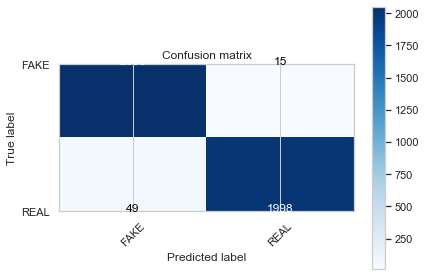

In [205]:
cm = metrics.confusion_matrix(Y_test, predictions, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

The model achieved an accuracy of 98.4%. It also achieved high recall and precision, thus has a low false negative rate and low false positive rate respectively. The high recall and precision is reflected in the high F1 score.

Therefore, this model performed very well in detecting fake news.